# 02 - Randomized Experiments and Stats Review
 
## Brute Force Independence with Randomization


## An A/B Testing Example
  

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 5)


In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv("./data/cross_sell_email.csv")
data

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
...,...,...,...,...
321,1,no_email,16,0
322,1,long,24,1


In [3]:
(data
 .groupby(["cross_sell_email"])
 .mean())

,gender,age,conversion
cross_sell_email,,,
long,0.550459,21.752294,0.055046
no_email,0.542553,20.489362,0.042553
short,0.633333,20.991667,0.125000



### Checking for Balance 
 

In [4]:
X = ["gender", "age"]

mu = data.groupby("cross_sell_email")[X].mean()
var = data.groupby("cross_sell_email")[X].var()

norm_diff = (mu - mu.loc["no_email"])/np.sqrt((var + var.loc["no_email"])/2)

norm_diff

,gender,age
cross_sell_email,,
long,0.015802,0.221423
no_email,0.000000,0.000000
short,0.184341,0.087370


## The Ideal Experiment
 

 
## The Most Dangerous Equation
 

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from cycler import cycler

default_cycler = (cycler(color=['0.3', '0.5', '0.7', '0.5']))

color=['0.3', '0.5', '0.7', '0.9']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

In [6]:
df = pd.read_csv("data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
...,...,...,...,...
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


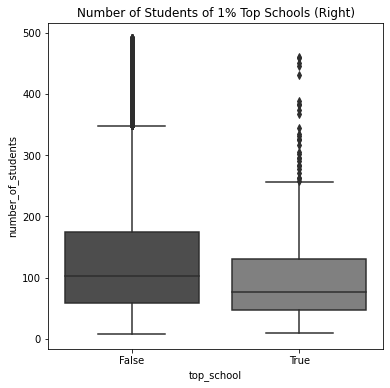

In [7]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

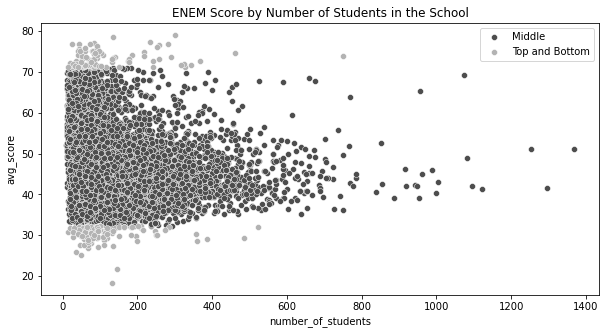

In [8]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([(d["avg_score"] > q_99) | (d["avg_score"] < q_01)],
                                                 ["Top and Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", data=plot_data.query("Group=='Middle'"), label="Middle")
sns.scatterplot(y="avg_score", x="number_of_students", data=plot_data.query("Group!='Middle'"), color="0.7", label="Top and Bottom")

plt.title("ENEM Score by Number of Students in the School");

##  The Standard Error of Our Estimates
 

In [9]:
data = pd.read_csv("./data/cross_sell_email.csv")

short_email = data.query("cross_sell_email=='short'")["conversion"]
long_email = data.query("cross_sell_email=='long'")["conversion"]
email = data.query("cross_sell_email!='no_email'")["conversion"]
no_email = data.query("cross_sell_email=='no_email'")["conversion"]

data.groupby("cross_sell_email").size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64

In [10]:
def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Long Email:", se(long_email))
print("SE for Short Email:", se(short_email))

SE for Long Email: 0.021946024609185506
SE for Short Email: 0.030316953129541618


In [11]:
print("SE for Long Email:", long_email.sem())
print("SE for Short Email:", short_email.sem())

SE for Long Email: 0.021946024609185506
SE for Short Email: 0.030316953129541618


## Confidence Intervals
 

In [12]:
n = 100
conv_rate = 0.08

def run_experiment(): 
    return np.random.binomial(1, conv_rate, size=n)

np.random.seed(42)

experiments = [run_experiment().mean() for _ in range(10000)]

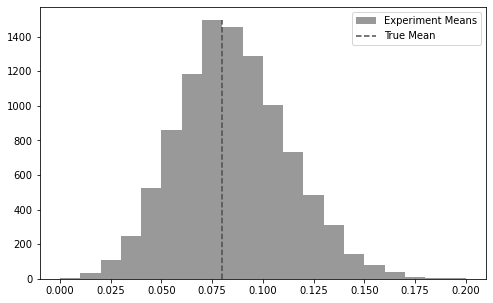

In [13]:
plt.figure(figsize=(8,5))
freq, bins, img = plt.hist(experiments, bins=20, label="Experiment Means", color="0.6")
plt.vlines(conv_rate, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="0.3")
plt.legend();

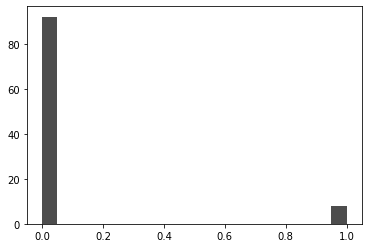

In [14]:
np.random.seed(42)
plt.hist(np.random.binomial(1, 0.08, 100), bins=20);

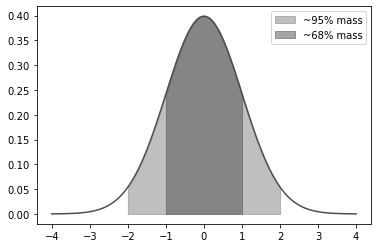

In [15]:
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, linestyle="solid")
plt.fill_between(x.clip(-2, +2), 0, y, alpha=0.5, label="~95% mass", color="C1")
plt.fill_between(x.clip(-1, +1), 0, y, alpha=0.5, label="~68% mass", color="C0")
plt.legend()
plt.show()

In [16]:
exp_se = short_email.sem()
exp_mu = short_email.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print("95% CI for Short Email: ", ci)

95% CI for Short Email:  (0.06436609374091676, 0.18563390625908324)


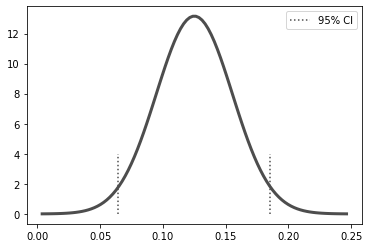

In [17]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.legend()
plt.show()

In [18]:
from scipy import stats

z = stats.norm.ppf(.995)
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(0.04690870373460816, 0.20309129626539185)

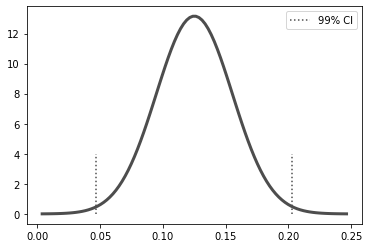

In [19]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="99% CI")
plt.legend()
plt.show()

In [20]:
def ci(y: pd.Series):
    return (y.mean() - 2 * y.sem(), y.mean() + 2 * y.sem())

print("95% CI for Short Email:", ci(short_email))
print("95% CI for Long Email:", ci(long_email))
print("95% CI for No Email:", ci(no_email))

95% CI for Short Email: (0.06436609374091676, 0.18563390625908324)
95% CI for Long Email: (0.01115382234126202, 0.09893792077800403)
95% CI for No Email: (0.0006919679286838468, 0.08441441505003955)


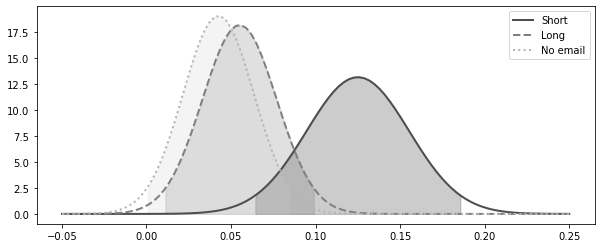

In [21]:
plt.figure(figsize=(10,4))

x = np.linspace(-0.05, .25, 100)
short_dist = stats.norm.pdf(x, short_email.mean(), short_email.sem())
plt.plot(x, short_dist, lw=2, label="Short", linestyle=linestyle[0])
plt.fill_between(x.clip(ci(short_email)[0], ci(short_email)[1]), 0, short_dist, alpha=0.2, color="0.0")

long_dist = stats.norm.pdf(x, long_email.mean(), long_email.sem())
plt.plot(x, long_dist, lw=2, label="Long", linestyle=linestyle[1])
plt.fill_between(x.clip(ci(long_email)[0], ci(long_email)[1]), 0, long_dist, alpha=0.2, color="0.4")

no_email_dist = stats.norm.pdf(x, no_email.mean(), no_email.sem())
plt.plot(x, no_email_dist, lw=2, label="No email", linestyle=linestyle[2])
plt.fill_between(x.clip(ci(no_email)[0], ci(no_email)[1]), 0, no_email_dist, alpha=0.2, color="0.8")

plt.legend()
plt.show()

## Hypothesis Testing
 

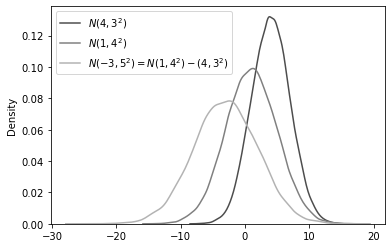

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt

np.random.seed(123)

n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1

sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(-3, 5^2) = N(1,4^2) - (4,3^2)$")
plt.legend()
plt.show()

In [23]:
diff_mu = short_email.mean() - no_email.mean()
diff_se = np.sqrt(no_email.sem()**2 + short_email.sem()**2)

ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(f"95% CI for the different (short email - no email):\n{ci}")

95% CI for the different (short email - no email):
(0.01023980847439844, 0.15465380854687816)


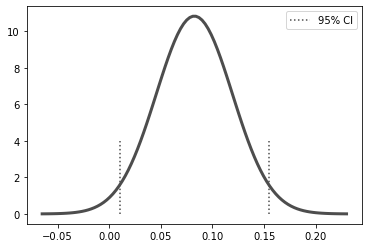

In [24]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.legend()
plt.show()

### Null Hypothesis
 

In [25]:
diff_mu_shifted =  short_email.mean() - no_email.mean() - 0.01 # shifting the CI
diff_se = np.sqrt(no_email.sem()**2 + short_email.sem()**2)

ci = (diff_mu_shifted - 1.96*diff_se, diff_mu_shifted + 1.96*diff_se)
print(f"95% CI 1% difference between (short email - no email):\n{ci}")

95% CI 1% difference between (short email - no email):
(0.00023980847439844521, 0.14465380854687815)



### Test Statistic


In [26]:
t_stat = (diff_mu - 0) / diff_se
t_stat

2.2379512318715364


## P-values


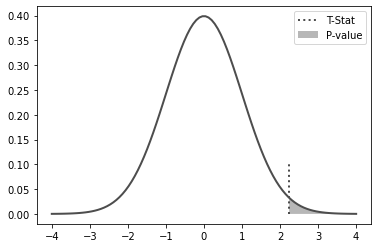

In [27]:
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, lw=2)
plt.vlines(t_stat, ymin=0, ymax=0.1, ls="dotted", label="T-Stat", lw=2)
plt.fill_between(x.clip(t_stat), 0, y, alpha=0.4, label="P-value")
plt.legend()
plt.show()

In [28]:
print("P-value:", (1 - stats.norm.cdf(t_stat))*2)

P-value: 0.025224235562152142


In [29]:
print("P-value:", (1 - stats.t.cdf(t_stat, df=len(short_email)+len(long_email) - 2))*2)

P-value: 0.02619511470984559


## Power
 

In [30]:
stats.norm.cdf(0.84)

0.7995458067395503

### Sample Size Calculation


In [31]:
np.ceil(16 * no_email.std()**2/0.01)

66.0

In [32]:
data.groupby("cross_sell_email").size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64

## Key Ideas
 